# Anomaly Detection using Keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
from datetime import datetime

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K

from keras.models import load_model
import keras.losses

Using TensorFlow backend.


In [2]:
### READ DATA AND CREATE FEATURES FOR year, month, day, hour ###
df = pd.read_csv('dataset/constant-test.csv')
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df["total"] = pd.to_numeric(df.total, errors='coerce')
df["total_tcp"] = pd.to_numeric(df.total_tcp, errors='coerce')
df["total_http"] = pd.to_numeric(df.total_http, errors='coerce')
df["total_udp"] = pd.to_numeric(df.total_udp, errors='coerce')
df["size"] = pd.to_numeric(df.size, errors='coerce')
df["size_tcp"] = pd.to_numeric(df.size_tcp, errors='coerce')
df["size_http"] = pd.to_numeric(df.size_http, errors='coerce')
df["size_udp"] = pd.to_numeric(df.size_udp, errors='coerce')
df.head()

,datetime,total,total_tcp,total_http,total_udp,size,size_tcp,size_http,size_udp
0,2012-03-16 12:35:00,1800,400,1000,400,92484,400,3000,450
1,2012-03-16 12:40:00,1800,400,1000,400,92484,400,3000,450
2,2012-03-16 12:45:00,1800,400,1000,400,92484,400,3000,450
3,2012-03-16 12:50:00,1800,400,1000,400,92484,400,3000,450
4,2012-03-16 12:55:00,1800,400,1000,400,92484,400,3000,450


In [3]:
df.dtypes

datetime      datetime64[ns]
total                  int64
total_tcp              int64
total_http             int64
total_udp              int64
size                   int64
size_tcp               int64
size_http              int64
size_udp               int64
dtype: object

In [4]:
df.columns = ['timestamp','total','total_tcp','total_http','total_udp','size','size_tcp','size_http','size_udp']

(array([22223355, 22249730]), <a list of 2 Text xticklabel objects>)

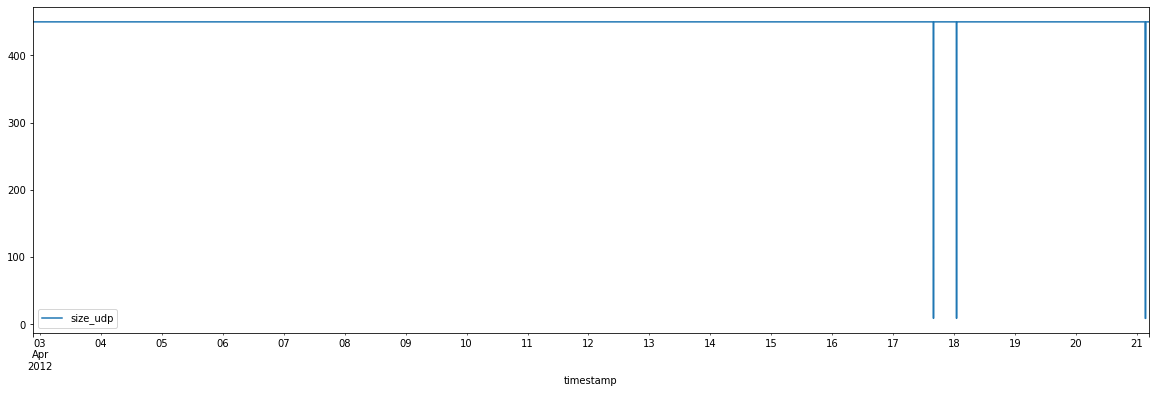

In [5]:
df.iloc[5000:,].plot(y='size_udp',x='timestamp',figsize=(20,6))
plt.xticks(rotation=70)

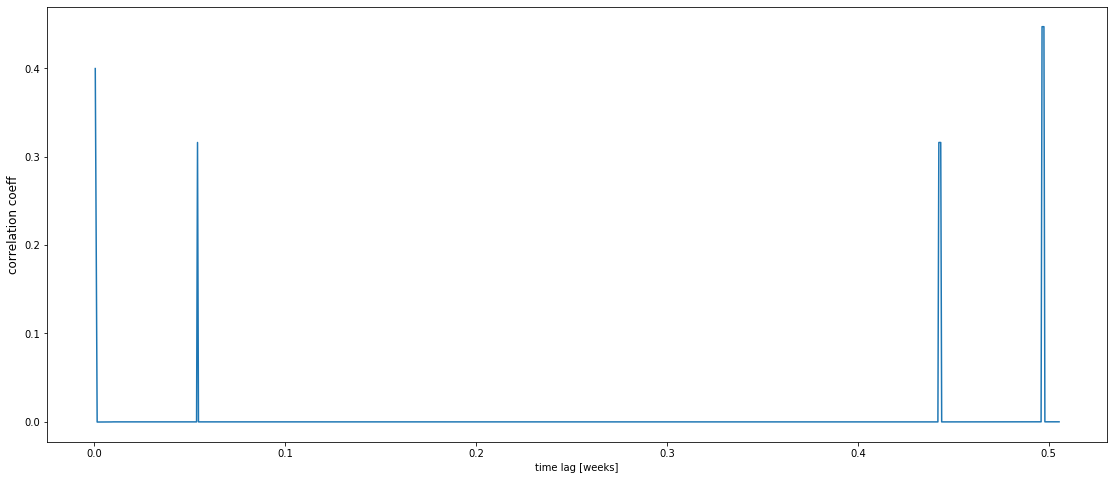

In [6]:
### WEEKLY AUTOCORR PLOT (5 WEEKS DEPTH) ###
timeLags = np.arange(1,288*7*5)
autoCorr = [df.total.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(288 * 7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [7]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###
weekday = df['timestamp'].dt.dayofweek
df['weekday'] = weekday

H = df['timestamp'].dt.hour
df['H'] = H

df.head()

,timestamp,total,total_tcp,total_http,total_udp,size,size_tcp,size_http,size_udp,weekday,H
0,2012-03-16 12:35:00,1800,400,1000,400,92484,400,3000,450,4,12
1,2012-03-16 12:40:00,1800,400,1000,400,92484,400,3000,450,4,12
2,2012-03-16 12:45:00,1800,400,1000,400,92484,400,3000,450,4,12
3,2012-03-16 12:50:00,1800,400,1000,400,92484,400,3000,450,4,12
4,2012-03-16 12:55:00,1800,400,1000,400,92484,400,3000,450,4,12


In [8]:
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['size_udp'].mean().to_dict())

In [27]:
df[:5000].groupby('weekday_hour')['size_udp'].head()

0       450
1       450
2       450
3       450
4       450
       ... 
1997    450
1998    450
1999    450
2000    450
2001    450
Name: size_udp, Length: 840, dtype: int64

In [10]:
### CREATE GENERATOR FOR LSTM ###
sequence_length = 288

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [11]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 
cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['size_udp']):
    cnt.append(sequence)
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

In [12]:
cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean

In [13]:
df.m_weekday[sequence_length:].shape

(9988,)

In [14]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###
init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.size_udp[sequence_length:].apply(np.log).values - init
label.shape
df.m_weekday

0        450
1        450
2        450
3        450
4        450
        ... 
10271    450
10272    450
10273    450
10274    450
10275    450
Name: m_weekday, Length: 10276, dtype: int64

In [15]:
### DEFINE QUANTILE LOSS ###
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [16]:
### TRAIN TEST SPLIT ###
X_train, X_test = cnt[:7000], cnt[7000:]
y_train, y_test = label[:7000], label[7000:]

In [17]:
### CREATE MODEL ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)

model = Model(inputs, [out10,out50,out90])
model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

W0813 14:47:18.576858 4699682240 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 14:47:18.611757 4699682240 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 14:47:18.615776 4699682240 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 14:47:18.756128 4699682240 deprecation.py:506] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow

In [18]:
history = model.fit(X_train, [y_train,y_train,y_train], epochs=1, batch_size=128, verbose=2, shuffle=True)

W0813 14:47:20.042755 4699682240 deprecation.py:323] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0813 14:47:22.381306 4699682240 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0813 14:47:22.588052 4699682240 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
 - 116s - loss: 0.0013 - dense_2_loss: 6.5748e-04 - dense_3_loss: 0.0019 - dense_4_loss: 0.0017


In [19]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

# for i in tqdm.tqdm(range(0,100)):
predd = NN([X_test, 0.5])
pred_10.append(predd[0])
pred_50.append(predd[1])
pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0]
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

In [20]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[len(init) - len(X_test):])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[len(init) - len(X_test)])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[len(init) - len(X_test):])

In [21]:
### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test + init[len(init) - len(X_test):]), pred_50_m)

0.024498889123148935

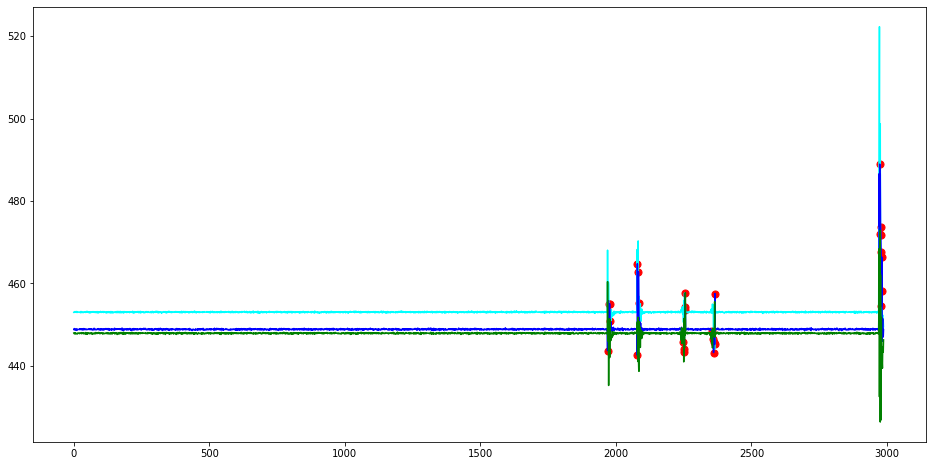

In [22]:
### PLOT QUANTILE PREDICTIONS ###
plt.figure(figsize=(16,8))
plt.plot(pred_90_m, color='cyan')
plt.plot(pred_50_m, color='blue')
plt.plot(pred_10_m, color='green')

### CROSSOVER CHECK ###
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

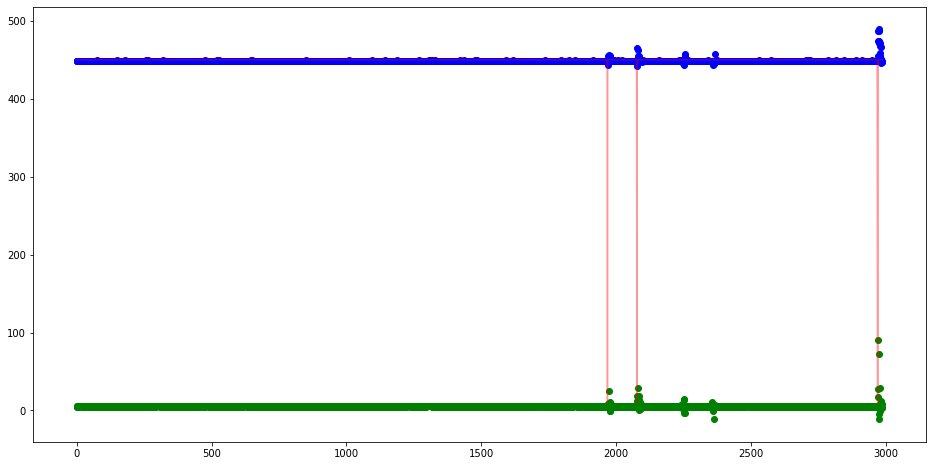

In [23]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test + init[len(init) - len(X_test):]), color='red', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m, color='green')
plt.scatter(range(len(pred_10_m)), pred_50_m, color='blue')


In [24]:
y = pred_90_m - pred_10_m

In [ ]:
y.shape

## Saving the model

In [ ]:
model.save_weights('saved_weights/size_udp.h5')
# del model

## Reload the model

In [ ]:
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def reload_model():
    losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
    lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
    dense = Dense(50)(lstm)
    out10 = Dense(1)(dense)
    out50 = Dense(1)(dense)
    out90 = Dense(1)(dense)

    model = Model(inputs, [out10,out50,out90])
    model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
    return model

## Resume Training

In [ ]:
def resume_training(X_train, y_train, save_path):
    model = reload_model()
    print("Model loaded")
    model.load_weights(save_path)
    history = model.fit(X_train, [y_train,y_train,y_train], epochs=1, batch_size=128, verbose=2, shuffle=True)
    print("Model Trained")
    model.save_weights(save_path)
    print("Model Saved")
    

In [ ]:
def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)): 
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))
        
def online_training(csv_name):
    print("Online Training")
    df = pd.read_csv(csv_name)
    df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
    df["total"] = pd.to_numeric(df.total, errors='coerce')
    df["total_tcp"] = pd.to_numeric(df.total_tcp, errors='coerce')
    df["total_http"] = pd.to_numeric(df.total_http, errors='coerce')
    df["total_udp"] = pd.to_numeric(df.total_udp, errors='coerce')
    df["size"] = pd.to_numeric(df.size, errors='coerce')
    df["size_tcp"] = pd.to_numeric(df.size_tcp, errors='coerce')
    df["size_http"] = pd.to_numeric(df.size_http, errors='coerce')
    df["size_udp"] = pd.to_numeric(df.size_udp, errors='coerce')
    df.columns = ['timestamp','total','total_tcp','total_http','total_udp','size','size_tcp','size_http','size_udp']
    
    weekday = df['timestamp'].dt.dayofweek
    df['weekday'] = weekday

    H = df['timestamp'].dt.hour
    df['H'] = H

    df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
    df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['size_udp'].mean().to_dict())

    sequence_length = 288
    
    cnt, mean = [], []
    for sequence in gen_index(df, sequence_length, ['size_udp']):
        cnt.append(sequence)
    for sequence in gen_index(df, sequence_length, ['m_weekday']):
        mean.append(sequence)
        
    cnt, mean = np.log(cnt), np.log(mean)
    cnt = cnt - mean
    
    init = df.m_weekday[sequence_length:].apply(np.log).values
    label = df.size_udp[sequence_length:].apply(np.log).values - init

    X_train = cnt
    y_train = label
    
    save_path = 'saved_weights/test.h5'
    
    print("Starting to resume training")
    resume_training(X_train, y_train, save_path)
    
    print("Online Training done")


In [ ]:
def get_prediction(input_data):
    model = reload_model()
    
    pred_10, pred_50, pred_90 = [], [], []
    NN = K.function([model.layers[0].input, K.learning_phase()], 
                    [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

    # for i in tqdm.tqdm(range(0,100)):
    predd = NN([input_data, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

    pred_10 = np.asarray(pred_10)[:,:,0]
    pred_50 = np.asarray(pred_50)[:,:,0]
    pred_90 = np.asarray(pred_90)[:,:,0]
    
    pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[len(init) - len(X_test):])
    pred_50_m = np.exp(pred_50.mean(axis=0) + init[len(init) - len(X_test)])
    pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[len(init) - len(X_test):])
    
    
    f_pred = np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
        pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)]
    
    return f_pred

## Script to test online training

In [ ]:
csv_name = 'dataset/sample-2.csv'
online_training(csv_name)

In [ ]:
df = pd.read_csv('dataset/constant-test.csv')
get_prediction()

In [ ]:
test = 

X_test[0]
X_test[0].shape

In [ ]:
cnt, mean = [], []
for sequence in gen_index(df.iloc[0:300], sequence_length, ['size_udp']):
    cnt.append(sequence)
# for sequence in gen_index(df, sequence_length, ['m_weekday']):
#     mean.append(sequence)


In [ ]:
len(cnt)